# Machine Learning Engineer Nanodegree
## Capstone Project
Simon Jackson
March 21st, 2017

---

In [1]:
import os
import numpy as np
import pandas as pd

from scripts import utility
from scipy.spatial.distance import cosine

# Pretty display for notebooks
%matplotlib inline

## Data Importing and preprocessing

Data was downloaded as .zip format...

Extract all data from zip files into the same directory

In [2]:
# Utility variables
data_directory = "data"

In [3]:
from scripts import extract_zips

# Extract all files from zip folders in data directory,
# into data directory
if False:
    extract_zips.extract_all(data_directory)
else:
    print "Extraction turned off. Check that files have been extracted."
    
print "\nFiles in the data directory:\n"
for f in os.listdir(data_directory):
    print "- " + f

Extraction turned off. Check that files have been extracted.

Files in the data directory:

- genome_scores.csv
- genome_tags.csv
- imdb-5000-movie-dataset.zip
- link.csv
- movie.csv
- movielens-20m-dataset.zip
- movie_metadata.csv
- rating.csv
- tag.csv


### IMDB data

In [4]:
from scripts import data_imdb

imdb = data_imdb.prep(data_directory)
print 'After prep, IMDB data set has {} rows and {} columns'.format(*imdb.shape)

Preparing IMDB data...

- Read in .csv file with 5043 rows and 28 columns
- Dropped unneeded variables
- Dummy coded `language` to boolean, `english`
- Dummy coded `country` to two boolean vars, `usa`, `uk`
- Dummy coded `color` to boolean.
- Dummy coded `content_ratings` to multiple columns
- Dummy coded `genres` to multiple columns
- Distribution adjustments applied to selected float variables
- All float variables normalized to range between 0 to 1
- Missing values imputed as mean/mode
- Extracted IMDB movie ids as `imdb_id` from url in `movie_imdb_link`

Prep of IMDB data completed.

After prep, IMDB data set has 5043 rows and 66 columns


In [5]:
# Column types
imdb.dtypes

color                           bool
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_1_facebook_likes       float64
gross                        float64
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
num_user_for_reviews         float64
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
movie_facebook_likes           int64
english                         bool
usa                             bool
uk                              bool
approved                       int32
g                              int32
gp                             int32
m                              int32
nc-17                          int32
not rated                      int32
p

In [6]:
# Examine few rows
imdb.head(n = 5)

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,movie_title,num_voted_users,cast_total_facebook_likes,...,news,reality-tv,romance,sci-fi,short,sport,thriller,war,western,imdb_id
0,True,0.940956,0.339286,0.000000,0.037174,0.001563,1.000000,Avatar,886204,4834,...,0,0,0,1,0,0,0,0,0,0499549
1,True,0.595284,0.321429,0.024478,0.043478,0.062500,0.637673,Pirates of the Caribbean: At World's End,471220,48350,...,0,0,0,0,0,0,0,0,0,0449088
2,True,0.855434,0.279762,0.000000,0.007000,0.017188,0.512689,Spectre,275868,11700,...,0,0,0,0,0,0,1,0,0,2379713
3,True,1.000000,0.311508,0.956522,1.000000,0.042188,0.767521,The Dark Knight Rises,1144337,106759,...,0,0,0,0,0,0,1,0,0,1345836
4,False,0.353411,0.198812,0.005696,0.028044,0.000205,0.202070,Star Wars: Episode VII - The Force Awakens ...,8,143,...,0,0,0,0,0,0,0,0,0,5289954


This information will be used for content-based filtering of movies.

**Plots of categorical/dummy variables**

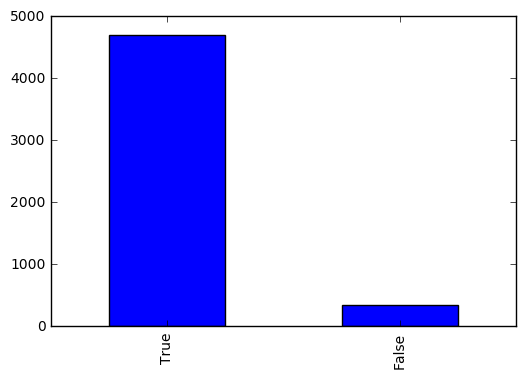

In [7]:
utility.count_plot(imdb.english)

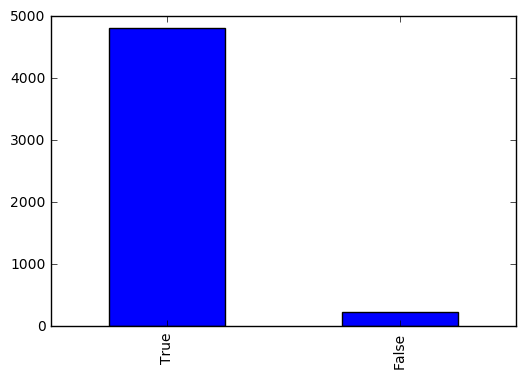

In [8]:
utility.count_plot(imdb['color'])

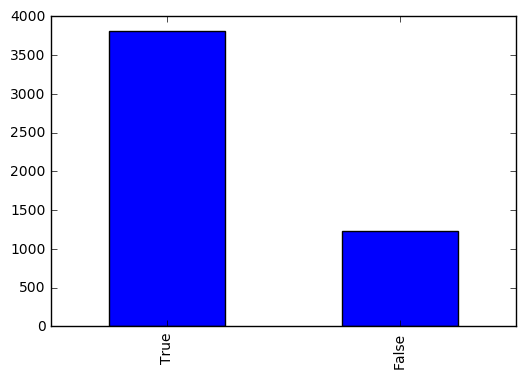

In [9]:
# Visualizing counts for two major countries (USA and UK)
utility.count_plot(imdb.usa)

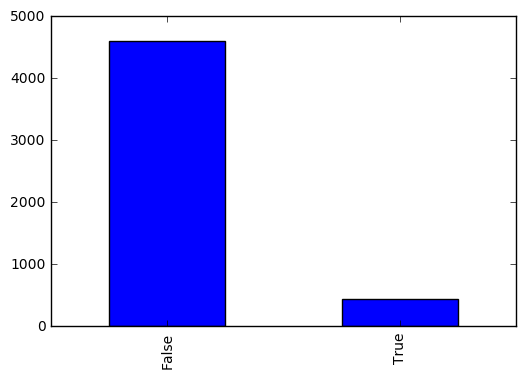

In [10]:
utility.count_plot(imdb.uk)

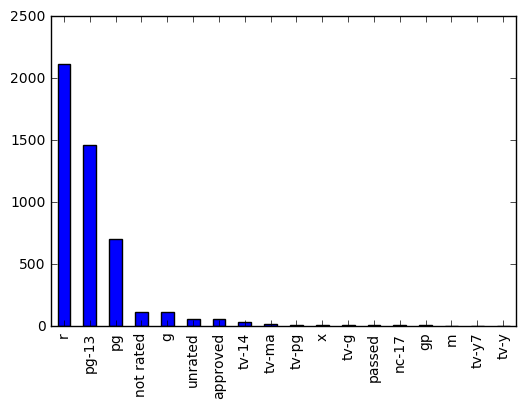

In [11]:
rating_dummies = pd.melt(imdb.ix[:, 'approved':'x'])
utility.count_plot(rating_dummies.variable[rating_dummies.value == 1])

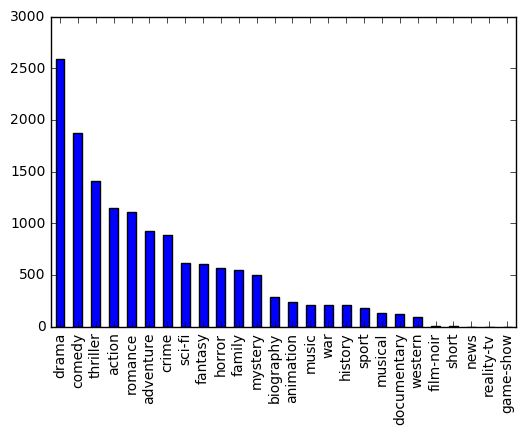

In [12]:
# Visualise counts of genres
genre_dummies = pd.melt(imdb.ix[:, 'action':'western'])
utility.count_plot(genre_dummies.variable[genre_dummies.value == 1])

#### Categorical variables

- `language`: convert to 1 = English, 0 = other
- `genres`: will need to be split into multiple variables indicating whether certain genres were tagged.
- `country`: 1 = USA, 0 = Other (possibly a separate one for UK?)
- `content_rating`: will need a number of categories (R, PG, PG-13, G, etc)

In [13]:
# Plots as examples to run if need to...

#imdb.plot.scatter('num_critic_for_reviews', 'director_facebook_likes')
#utility.float_scatter_matrix(imdb)

In [14]:
imdb.head(3)

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,movie_title,num_voted_users,cast_total_facebook_likes,...,news,reality-tv,romance,sci-fi,short,sport,thriller,war,western,imdb_id
0,True,0.940956,0.339286,0.000000,0.037174,0.001563,1.000000,Avatar,886204,4834,...,0,0,0,1,0,0,0,0,0,0499549
1,True,0.595284,0.321429,0.024478,0.043478,0.062500,0.637673,Pirates of the Caribbean: At World's End,471220,48350,...,0,0,0,0,0,0,0,0,0,0449088
2,True,0.855434,0.279762,0.000000,0.007000,0.017188,0.512689,Spectre,275868,11700,...,0,0,0,0,0,0,1,0,0,2379713


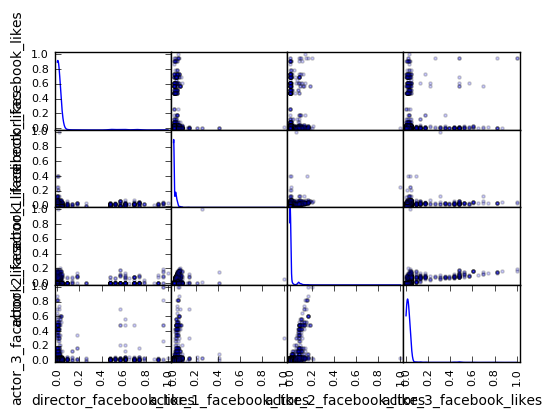

In [15]:
utility.float_scatter_matrix(imdb[['director_facebook_likes',
                                   'actor_1_facebook_likes',
                                   'actor_2_facebook_likes',
                                   'actor_3_facebook_likes']])

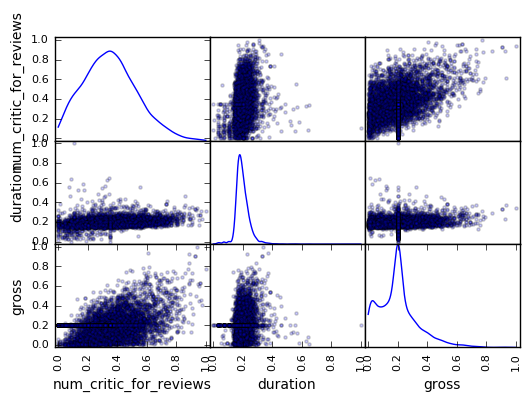

In [16]:
utility.float_scatter_matrix(imdb[['num_critic_for_reviews',
                                   'duration',
                                   'gross',
                                   'num_voted_users',
                                   'cast_total_facebook_likes']])

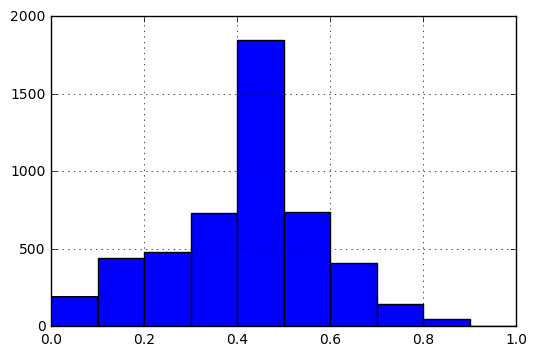

In [17]:
#np.log(imdb.actor_1_facebook_likes + .1).hist()
#np.sqrt(imdb.num_critic_for_reviews + .1).hist()
#(imdb.num_critic_for_reviews + .1).hist()

np.sqrt(imdb.gross).hist()

In [18]:
#from scipy.stats import norm

#np.histogram(norm.pdf(imdb.num_critic_for_reviews))
#np.histogram(norm.ppf((imdb.num_critic_for_reviews.rank() - .5) / len(imdb)))

In [19]:
x = imdb.drop(['movie_title', 'imdb_id'], axis=1)

nrow = x.shape[0]
similarity = np.array([0.0]*nrow)
test_i = 100

for i in xrange(nrow):
    similarity[i] = 1 - cosine(x.iloc[test_i], x.iloc[i])

#print str(np.nanmin(similarity)) + ' ' + str(np.nanmax(similarity))
#most_similar = np.argpartition(similarity[np.logical_not(np.isnan(similarity))], -5)[-5:]
most_similar = np.argpartition(similarity, -5)[-5:]

print imdb[['movie_title', 'imdb_id']].iloc[test_i]
print imdb[['movie_title', 'imdb_id']].iloc[most_similar]

movie_title    The Fast and the Furious 
imdb_id                          0232500
Name: 100, dtype: object
                    movie_title  imdb_id
2803           Little Children   0404203
2519              How She Move   0770810
1332  The Fast and the Furious   0232500
395   The Fast and the Furious   0232500
100   The Fast and the Furious   0232500


In [26]:
list(imdb)

['color',
 'num_critic_for_reviews',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_1_facebook_likes',
 'gross',
 'movie_title',
 'num_voted_users',
 'cast_total_facebook_likes',
 'facenumber_in_poster',
 'num_user_for_reviews',
 'budget',
 'title_year',
 'actor_2_facebook_likes',
 'imdb_score',
 'aspect_ratio',
 'movie_facebook_likes',
 'english',
 'usa',
 'uk',
 'approved',
 'g',
 'gp',
 'm',
 'nc-17',
 'not rated',
 'passed',
 'pg',
 'pg-13',
 'r',
 'tv-14',
 'tv-g',
 'tv-ma',
 'tv-pg',
 'tv-y',
 'tv-y7',
 'unrated',
 'x',
 'action',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'thriller',
 'war',
 'western',
 'imdb_id']

In [32]:
list(imdb.drop(['movie_title', 'imdb_id'], axis=1).sample(10, axis=1))

['comedy',
 'music',
 'gp',
 'uk',
 'tv-ma',
 'cast_total_facebook_likes',
 'g',
 'budget',
 'num_critic_for_reviews',
 'aspect_ratio']

In [64]:
"""
Return list of most similar to target
- note, for sanity check, should include SAME movie in list
"""
def test_similarity(df, target_i, n_similar = 5):
    
    nrow = df.shape[0]
    similarity = np.array([0.0]*nrow)

    for i in xrange(nrow):
        similarity[i] = 1 - cosine(df.iloc[target_i], df.iloc[i])

    return np.argpartition(similarity, -n_similar)[-n_similar:]

In [68]:
# Remove title and id
x = imdb.drop(['movie_title', 'imdb_id'], axis=1)

# Random columns for testing
#x = imdb.drop(['movie_title', 'imdb_id'], axis=1).sample(10, axis=1)

# genre
#x = imdb.loc[:, 'action':'western']

# Rating and genre
#x = imdb.loc[:, 'approved':'western']


# Stuff
#x = pd.concat([imdb.loc[:, 'action':'western'], imdb[['gross', 'color']]], axis=1, join='inner')


target_i = 2051  # Star wars V
n_similar = 10

print 'Target movie:\n'
print imdb[['movie_title', 'imdb_id']].iloc[target_i]

print '\nUsing all variables...\n'
most_similar = test_similarity(x, target_i, n_similar)
print imdb[['movie_title', 'imdb_id']].iloc[most_similar]

print '\nUsing genre only...\n'
most_similar = test_similarity(x.loc[:, 'action':'western'], target_i, n_similar)
print imdb[['movie_title', 'imdb_id']].iloc[most_similar]

print '\nUsing genre and content rating...\n'
most_similar = test_similarity(x.loc[:, 'approved':'western'], target_i, n_similar)
print imdb[['movie_title', 'imdb_id']].iloc[most_similar]

print '\nGenre, rating, gross, cast likes...\n'
most_similar = test_similarity(pd.concat([x.loc[:, 'action':'western'],
                                          x[['gross', 'cast_total_facebook_likes']]],
                                         axis=1, join='inner')
                               , target_i, n_similar)
print imdb[['movie_title', 'imdb_id']].iloc[most_similar]

Target movie:

movie_title    Star Wars: Episode V - The Empire Strikes Back 
imdb_id                                                0080684
Name: 2051, dtype: object

Using all variables...

                                            movie_title  imdb_id
2101                                  Saving Silverman   0239948
1109                                          Cellular   0337921
119                                        Ratatouille   0382932
270   The Lord of the Rings: The Fellowship of the R...  0120737
1536        Star Wars: Episode VI - Return of the Jedi   0086190
157                             Fun with Dick and Jane   0369441
1110                                    Johnny English   0274166
4176                                  Silver Medallist   0851515
2051    Star Wars: Episode V - The Empire Strikes Back   0080684
654                                         The Matrix   0133093

Using genre only...

                                          movie_title  imdb_id
3024    

In [46]:
list(x)

['approved',
 'actor_1_facebook_likes',
 'aspect_ratio',
 'comedy',
 'romance',
 'tv-y7',
 'fantasy',
 'm',
 'adventure',
 'pg']